In [3]:
import nearl
import pytraj as pt

topfile = "/MieT5/BetaPose_trajs/C209CsDJQucZ_job_008_END.pdb"
trajfile = "/MieT5/BetaPose_trajs/C209CsDJQucZ_job_008_traj.nc"
traj = nearl.io.traj.Trajectory(trajfile, topfile)


In [ ]:
# Cosine similarity between frame i and the average distance matrix



pytraj.Trajectory, 1001 frames: 
Size: 0.478246 (GB)
<Topology: 21375 atoms, 6474 residues, 6324 mols, PBC with box type = cubic>
           
(21,)
(21, 1001)
0.9433218699346781 0.9980060025456746


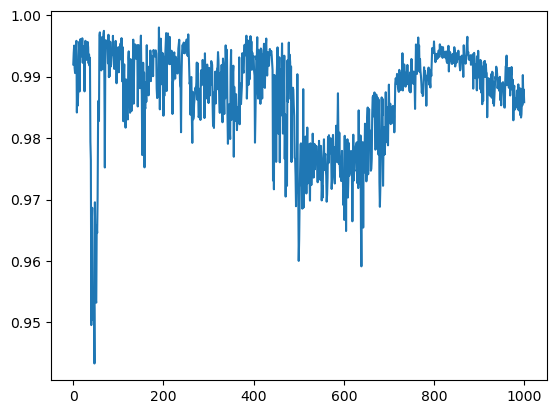

(5.0, 12.0)

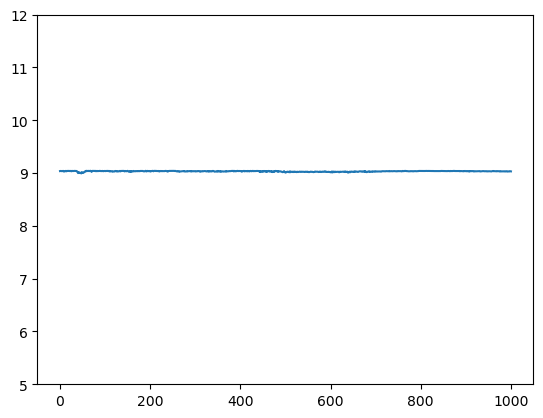

In [40]:
# from nearl import data
import nearl
import numpy as np
import matplotlib.pyplot as plt 


# traj = nearl.io.traj.Trajectory(*nearl.data.MINI_TRAJ)

lst = [
"/MieT5/BetaPose_trajs/C209CsDJQucZ_job_009_traj.nc",
"/MieT5/BetaPose_trajs/C209CsDJQucZ_job_004_END.pdb",
]
traj = nearl.io.traj.Trajectory(*lst)

print(traj)
traj.top.set_reference(traj[0])

dist, info = nearl.utils.dist_caps(traj, ":LIG&!@H=", ":LIG<:6&@CA,C,N,O,CB")

mean_dist = dist.mean(axis=1)
print(mean_dist.shape)


cosine_sim = [nearl.utils.cosine_similarity(i, mean_dist) for i in dist.T]

# print(dist, info)
print(dist.shape)
# print(cosine_sim)
print(min(cosine_sim), max(cosine_sim))
# Penalize the frames that are too different from the average.
# label = 

plt.plot(cosine_sim)
plt.show()

# range from 0-12

ref_val = 9
def penalties(cosine_sim, ref_val, scale_factor=0.1, max_val=0.95):
  # scale_factor represents the variability of the label
  # max_val represents the maximum cosine similarity that will not be penalized
  return (max_val - np.array(cosine_sim)) * ref_val * scale_factor
panelty = (0.95 - np.array(cosine_sim)) * ref_val* 0.1

# panelty = np.array([max(0,i) for i in ( - 0.7)]) * 0.3
plt.plot(ref_val - panelty)
plt.ylim(5, 12)


     pdbcode  resolution  year     pK comment
0       2r58        2.00  2007   2.00   (MLY)
1       3c2f        2.35  2008   2.00   (PRP)
2       3g2y        1.31  2009   2.00   (GF4)
3       3pce        2.06  1998   2.00   (3HP)
4       4qsu        1.90  2014   2.00   (TDR)
...      ...         ...   ...    ...     ...
5311    4f3c        1.93  2013  11.82   (BIG)
5312    5bry        1.34  2015  11.82   (4UY)
5313    1sl3        1.81  2004  11.85   (170)
5314    1ctu        2.30  1995  11.92   (ZEB)
5315    6e9a        1.22  2018  11.92   (J0S)

[5316 rows x 5 columns]


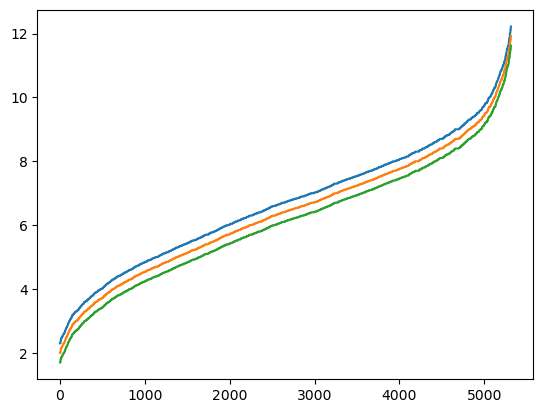

In [9]:
import pandas as pd 
import nearl

table = pd.read_csv(nearl.data.REFINED_SET)
print(table)

plt.plot(table.pK+0.3)
plt.plot(table.pK)
plt.plot(table.pK-0.3)
plt.show()

In [ ]:


########################
# trajid = "C008bfl1sim5"
# sessid = trajid[4:]
# trajfile = f"/storage006/yzhang/clean_acgui/TMP_FOLDERS/{sessid}/singleMD/{trajid}/{trajid}_ATJ.nc"; 
# topfile  = f"/storage006/yzhang/clean_acgui/TMP_FOLDERS/{sessid}/singleMD/{trajid}/{trajid}_PDB.pdb"; 
# traj = pt.load(trajfile, top=topfile, stride=STRIDE);
# traj.top.set_reference(traj[0]); 

# mask_lig = utils.getmask(traj, ":LIG&!@CA,CB,C,N,O"); 

# traj.superpose(":LIG<:5&@CA"); 
# traj.center(":LIG<:5&@CA"); 
########################



tv = TrajectoryViewer(traj); 
tv.show_complex(REPR); 
dist, info = utils.PairwiseDistance(traj, mask_lig_pair1, mask_lig_pair2)
tv.add_distance(info["gp1_ids"], info["gp2_ids"])
tv.viewer
# from nglview.contrib.movie import MovieMaker
# download_folder = '/storage006/yzhang/tests/'
# output = 'test.gif'
# mov = MovieMaker(tv.viewer, download_folder=download_folder, output=output)
# mov.make()

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.spatial import distance
from scipy import linalg

# Sum of the frames are they similar in values. 
print(f"Mean: {dist.mean()} ; Sum: {dist.sum()}")


sums = np.sum(dist, axis=0)
print(len(sums))
print(f"Mean: {sums.mean()} ; Std: {sums.std()}; Sum: {sums.sum()} , test = {dist.sum()/sums.mean()}, {dist.shape}")

print(6/200)

# plt.plot(sums)

# print(np.cov(dist.T))


# plt.pcolormesh(range(dist.shape[1]), range(dist.shape[0]), dist, cmap="inferno")
# plt.pcolormesh(range(201), range(33), dist, cmap="inferno")
# plt.pcolormesh(range(36), range(36), np.cov(theinv), cmap="inferno")
# print(dist.cov())
# print(dir(dist))


thecov = np.cov(dist)
theinv = linalg.inv(thecov)
meandist = dist.mean(axis=1)

# print(theinv)
# print(dist.shape[1])

def testmah(dist_mtx):
  thecov = np.cov(dist_mtx); 
  theinv = linalg.inv(thecov); 
  meandist = dist_mtx.mean(axis=1); 
  outarray = []
  for i in range(dist_mtx.shape[0]):
    disti = dist_mtx[:, i]; 
    thedist = distance.mahalanobis(meandist, disti, theinv)
    outarray.append(thedist)
  return np.array(outarray)
mahs = testmah(dist)
rmsd = pt.rmsd(traj, ":LIG&!@H="); 
print()
print(f"RMSD: {rmsd.mean()}, dist: {dist.mean()}, Mah: {mahs.mean()}")
print(f"RMSD: {rmsd.mean()}, dist: {dist.std()}, Mah: {mahs.std()}")
print(f"RMSD: {rmsd.mean()}, dist: {dist.mean()}, Mah: {mahs.mean()}")
print(f"RMSD: {rmsd.mean()}, dist: {dist.mean()}, Mah: {mahs.mean()}")
print(f"RMSD: {rmsd.mean()}, dist: {dist.std()/dist.mean()}, Mah: {mahs.std()/mahs.mean()}")


In [ ]:
import numpy as np 
import pytraj as pt
from scipy.spatial import distance
from scipy import linalg
from BetaPose import utils, view
import pandas as pd 
import os.path

def testmah(dist_mtx):
  thecov = np.cov(dist_mtx); 
  theinv = linalg.inv(thecov); 
  meandist = dist_mtx.mean(axis=1); 
  # meandist = dist_mtx[:,0]; 
  outarray = []
  for i in range(dist_mtx.shape[0]):
    disti = dist_mtx[:, i]; 
    thedist = distance.mahalanobis(meandist, disti, theinv)
    outarray.append(thedist)
  return np.array(outarray)
def MSD(arr):
  """
    Mean Spacing Deviation
  """
  return np.array(arr).std(axis=1).mean(); 
def MSCV(arr):
  """
    Mean Spacing Coefficient of Variation
  """
  std = np.array(arr).std(axis=1); 
  mean = np.array(arr).mean(axis=1); 
  mscv = (std/mean).mean()
  return min(mscv, 1); 


STRIDE   = 1
RMSLST = []
DSTLST = []
MSDLST = []
MVCLST = []
TRAJID = []
c = 0
for i in range(1, 6):
  for j in range(1, 15): 
    trajid = f"C{j:03d}bfl1sim{i}"; 
    sessid = trajid[4:]; 
    if os.path.isfile(f"/storage006/yzhang/clean_acgui/TMP_FOLDERS/{sessid}/singleMD/{trajid}/{trajid}_ATJ.nc"): 
      trajfile = f"/storage006/yzhang/clean_acgui/TMP_FOLDERS/{sessid}/singleMD/{trajid}/{trajid}_ATJ.nc"; 
    elif os.path.isfile(f"/storage006/yzhang/clean_acgui/TMP_FOLDERS/{sessid}/singleMD/{trajid}/{trajid}_TRJ.nc"): 
      trajfile = f"/storage006/yzhang/clean_acgui/TMP_FOLDERS/{sessid}/singleMD/{trajid}/{trajid}_TRJ.nc"; 
    else: 
      print(f"Not found trajectory ID {trajid}"); 
      continue
      
    topfile  = f"/storage006/yzhang/clean_acgui/TMP_FOLDERS/{sessid}/singleMD/{trajid}/{trajid}_PDB.pdb"; 
    
    traj = pt.load(trajfile, top=topfile, stride=STRIDE);
    traj.top.set_reference(traj[0]); 
    
    mask_lig = utils.getmask(traj, ":LIG&!@CA,CB,C,N,O"); 
    mask_superpose = utils.getmask(traj, f"{mask_lig}<:6&@CA&!{mask_lig}");
    mask_lig_pair1 = utils.getmask(traj, f"{mask_lig}&!@H="); 
    mask_lig_pair2 = utils.getmask(traj, f"{mask_lig}<:6&@CA,C,N,O,CB&!{mask_lig}"); 
    
    traj.superpose(mask_superpose);
    # traj.center(mask_superpose);

    mask_lig_pair1 = utils.getmask(traj, f"{mask_lig}&!@H=")
    mask_lig_pair2 = utils.getmask(traj, f"{mask_lig}<:6&@CA,C,N,O,CB&!{mask_lig}")
    dist, info = utils.PairwiseDistance(traj, mask_lig_pair1, mask_lig_pair2)
    dist += 0.0000001
    
    try: 
      mahs = testmah(dist)
    except: 
      mahs = np.zeros([dist.shape[0]])
    rmsds = pt.rmsd(traj, mask_lig_pair1, nofit=True); 
    
    rmsd = rmsds.mean()
    mdist = dist.mean(); 
    msd = MSD(dist); 
    mscv = MSCV(dist); 
    TRAJID.append(trajid); 
    RMSLST.append(rmsd)
    DSTLST.append(mdist)
    MSDLST.append(msd)
    MVCLST.append(mscv)
    print(f"{trajid}:{c:>3d} - RMSD: {rmsd:.2f} | Dist: {mdist:>5.2f} | MSD: {msd:>6.3f} | MSCV: {mscv:4.3f} | Mah: {mahs.mean() - MSCV(dist)*mahs.mean():>5.2f} ;")
    c+=1
    
finallst = pd.DataFrame([])
finallst["TRAJ"] = TRAJID
finallst["RMS"] = RMSLST
finallst["DIST"] = DSTLST
finallst["MSD"] = MSDLST
finallst["MSCV"] = MVCLST
# print(finallst)

In [ ]:
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
vals = finallst[["RMS", "DIST", "MSCV"]]



# sns.displot(vals[['RMS', "DIST"]], binwidth=0.1)
# sns.displot(vals[['MSD', "MSCV"]], binwidth=0.01)
x = np.corrcoef(vals.T)
print(x)

pca = PCA(n_components=2); 
pca.fit(vals[["MSCV", "RMS"]])
pca_x = np.linspace(0,0.4,100)
pca_y = np.linspace(0,4,100)
# pca_vals = np.meshgrid()
# print(pca_vals)

pca_vals = pca.transform([[i,j] for i, j in zip(pca_x, pca_y)])
print(pca_y.shape)

x = pd.DataFrame(x, columns=vals.columns, index=vals.columns)
# sns.heatmap(x, cmap="inferno", vmin=0, square=True)
# sns.displot(vals, binwidth=0.0)
# sns.pairplot(vals)


axis = sns.kdeplot(vals[['RMS', "MSCV"]], x="MSCV", y="RMS")

axis = sns.scatterplot(vals[['RMS', "MSCV"]], x="MSCV", y="RMS")


In [ ]:
import seaborn as sns; sns.set()

# MSCVlst = pd.DataFrame()
MSCVlst["MSCV_4PHE"] = finallst[["MSCV"]]

print(MSCVlst.shape)
# sns.histplot(rmslist)
# axis = sns.histplot(MSCVlst['MSCV_CE='], kde=True, bins=10)
dataset = MSCVlst #["MSCV_4850"]; 
# print(dataset)
# axis = sns.histplot(dataset, kde=True, binwidth=dataset.mean()/10)
axis = sns.histplot(dataset, kde=True, bins=10)
axis.tick_params(rotation=-15)
axis.set(ylim=(0, 25))
# for i in MSCVlst:
#   print(MSCVlst[i])


In [ ]:
import seaborn as sns; sns.set()

# rmslist=pd.DataFrame()
rmslist["RMS_4PHE"] = finallst[["RMS"]]

print(rmslist.shape)
dataset = rmslist["RMS_4PHE"]; 
# sns.histplot(rmslist, kde=True, bins=10)
axis = sns.histplot(dataset, kde=True, bins=10)

# axis = sns.histplot(dataset, kde=True, binwidth=dataset.mean()/10)
axis.set(ylim=(0, 25))


In [ ]:
print(rmslist.to_csv())
print(MSCVlst.to_csv())

In [ ]:
print(rmslist.to_csv())
print(MSCVlst.to_csv())

In [ ]:
print(rmslist.to_csv())
print(MSCVlst.to_csv())

In [ ]:
df = sns.load_dataset("penguins")
print(df)
sns.displot(
    df, x="flipper_length_mm", col="species", row="sex",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

In [ ]:
from sklearn.preprocessing import normalize
import seaborn as sns; 
import matplotlib.pyplot as plt 
# plt.scatter(finallst.MSD, finallst.RMS)
# plt.scatter(finallst.MSVC, finallst.RMS)
# plt.scatter(finallst.MSVC, finallst.MSD)
# plt.scatter(finallst.MSVC, finallst.DIST)
# sns.pairplot(finallst)
vals = finallst[["RMS", "DIST", "MSD", "MSVC"]].to_numpy().T


print(finallst.MSVC.max(), finallst.MSVC.mean() + 2*finallst.MSVC.std())


def reject_outliers(data, m=2):
  finallst.MSVC.mean() + 2*finallst.MSVC.std()
#   np.where(data<)




vals_norm = normalize(vals)
print(np.cov(vals))
print(linalg.inv(np.cov(vals)))
# vals_norm = vals
print(vals_norm.mean(), vals_norm.std())

plt.scatter(vals_norm[3,:], vals_norm[0,:])
plt.scatter(vals_norm[3,:], vals_norm[1,:])
plt.scatter(vals_norm[3,:], vals_norm[2,:])


# plt.pcolormesh(range(vals_norm.shape[1]), range(vals_norm.shape[0]), vals_norm)


In [ ]:
from nglview.contrib.movie import MovieMaker
download_folder = "/home/miemie/Downloads"
output = 'test.gif'
mov = MovieMaker(tv.viewer, download_folder=download_folder, in_memory=True, output=output)
mov.make()

In [ ]:
from time import sleep

# to save time for this tutorial, we make a movie with only 50 frames
for frame in range(0, 50):
    # set frame to update coordinates
    tv.viewer.frame = frame
    # make sure to let NGL spending enough time to update coordinates
    sleep(0.5)
    tv.viewer.download_image(filename=f'image{frame}.png')
    # make sure to let NGL spending enough time to render before going to next frame
    sleep(1.0)



In [ ]:
# import moviepy
import moviepy.editor as mpy


imagefiles = [f"/home/miemie/Downloads/image{i}.png" for i in range(0, 50, 1)]
print(imagefiles)

frame_per_second = 8
im = mpy.ImageSequenceClip(imagefiles, fps=frame_per_second)
im.write_gif('my_movie.gif', fps=frame_per_second)
